# Overview
- 画像で遊ぶ

In [1]:
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

3bc5895


# Const

In [2]:
NB = '009'
DIR_TRAIN = './../data_ignore/input/train/'
DIR_TEST = './../data_ignore/input/test/'
DIR_WIFI = './../data_ignore/input/wifi/'
PATH_SUB = './../data_ignore/input/sample_submission.csv'
PATH_99_SUB = './../data/input/floor_99per_acc_sub.csv'
DIR_SAVE_IGNORE = f'./../data_ignore/nb/{NB}/'
DIR_SAVE = f'./../data/nb/{NB}/'

In [3]:
config_str = '''
globals:
    seed: 5713
    device: cuda
    n_label: 24
    n_splits: 5
    random_sate: 42
    lr: 0.001
    patience: 10
    epoch: 100
    batch_size: 512
    skip_evaluate_num: 5
    num_feats: 20
    t_mux: 10
'''

# Import everything I need:)

In [4]:
import os
import time
import yaml
import json
import types
import random
import pickle
import builtins
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic
import matplotlib.pyplot as plt
from dataclasses import dataclass
# from tqdm import tqdm
from fastprogress import progress_bar, master_bar
from glob import glob
from loguru import logger
from collections import OrderedDict

# sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold

# pytorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

# Function

In [5]:
def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )


def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [6]:
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

# Preparation

load config

In [7]:
config = yaml.safe_load(config_str)
config

{'globals': {'seed': 5713,
  'device': 'cuda',
  'n_label': 24,
  'n_splits': 5,
  'random_sate': 42,
  'lr': 0.001,
  'patience': 10,
  'epoch': 100,
  'batch_size': 512,
  'skip_evaluate_num': 5,
  'num_feats': 20,
  't_mux': 10}}

<br>

set

In [8]:
seed_everything(config['globals']['seed'])
pd.set_option('display.max_rows', 500)

if not os.path.exists(DIR_SAVE_IGNORE):
    os.makedirs(DIR_SAVE_IGNORE)
if not os.path.exists(DIR_SAVE):
    os.makedirs(DIR_SAVE)

<br>

load dataset

In [9]:
sample_submission = pd.read_csv(PATH_SUB)
sub = pd.read_csv('./../data/nb/002/nb002_sub.csv')

# EDA

In [11]:
sub

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,86.470265,101.522876
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,78.126546,102.266641
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.247433,103.743515
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.940889,106.885060
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,88.091051,109.489136
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,214.266605,97.276553
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,210.642874,100.131723
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,204.117545,105.498964
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,202.371286,109.439828


In [12]:
site_path_timestamp = sub.site_path_timestamp.values

In [39]:
site_arr = []
path_arr = []
for val in site_path_timestamp:
    site, path, _ = val.split('_')
    site_arr.append(site)
    path_arr.append(path)
site_arr = np.array(site_arr)
path_arr = np.array(path_arr)

In [36]:
x_arr = sub.x.values
y_arr = sub.y.values

In [47]:
dir_image = './../data/nb/008/floor_images_with_trace/'

In [51]:
site_idx = 5

site_unique = sorted(np.unique(site_arr))
site = site_unique[site_idx]

floor_list = sorted(glob(f'{dir_image}{site}/*'))
floor_list = [text.split('/')[-1] for text in floor_list]
floor_list

['B1', 'F1', 'F2', 'F3', 'F4']

In [54]:
for i_floor, floor in enumerate(floor_list):
    path_img = f'{dir_image}{site}/{floor}/floor_image_with_trace.png'
    im = Image.open(path_img)

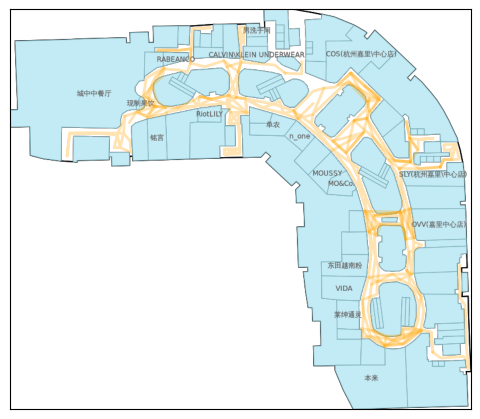

In [157]:
site_idx = 13
floor_idx = 2
dpi = 200

site = site_list[site_idx]
floor_list = sorted(glob(f'./../data_ignore/input/train/{site_list[site_idx]}/*'))
floor = [text.split('/')[-1] for text in floor_list][floor_idx]

# json
path_json = f'./../data_ignore/input/metadata/{site}/{floor}/floor_info.json'
with open(path_json) as json_file:
    json_data = json.load(json_file)
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]

# show image
# title = f'site: {site}\nfloor: {floor}'
path_img = f'./../data_ignore/input/metadata/{site}/{floor}/floor_image.png'
im = Image.open(path_img)

fig, ax = plt.subplots(1, 1, dpi=dpi)
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace = 0, wspace = 0)
ax.tick_params(
    axis='both',      
    which='both',   
    bottom=False,   
    left=False,    
    labelleft=False, 
    labelbottom=False) 
ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))

path_trace_list = sorted(glob(f'./../data_ignore/input/train/{site}/{floor}/*'))
for i_trace in range(len(path_trace_list)):
    data = read_data_file(path_trace_list[i_trace])
    waypoints = data.waypoint
    x_arr = waypoints[:, 1]
    y_arr = waypoints[:, 2]

    ax.plot(x_arr, y_arr, linewidth=2, alpha=0.3, color='orange')
fig.savefig('image.png', bbox_inches = 'tight', pad_inches = 0)